## Reproduce PySM 2 small scales using polspice
tags: [pysm,healpy,cosmology]

The purpose of this notebook is to reproduce the analysis described in the [PySM 2 paper](https://arxiv.org/pdf/1608.02841.pdf) to prepare the input templates used in the Galactic dust and synchrotron models.
In summary we take input template maps from Planck or other sources, smooth them to remove noise and add small scale gaussian fluctuations.

In [1]:
import os
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
%matplotlib inline

In [2]:
hp.disable_warnings()

In [3]:
plt.style.use("seaborn-talk")

In [4]:
import pysm3 as pysm
import pysm3.units as u

In [5]:
nside = 1024
lmax = 3 * nside - 1

## Masks

I initially thought the analysis of dust was using the combination of 2 masks:

* WMAP polarization analysis mask
* Planck Galactic plane mask

However, reading the paper more carefully it seems they were only using the Planck 80% Galactic mask (the WMAP ones is for synchrotron).

Anyway, I leave it in the notebook for testing purposes.

In [6]:
wmap_mask_filename = "wmap_polarization_analysis_mask_r9_9yr_v5.fits"

In [7]:
if not os.path.exists(wmap_mask_filename):
    !wget https://lambda.gsfc.nasa.gov/data/map/dr5/ancillary/masks/$wmap_mask_filename

In [8]:
fits.open(wmap_mask_filename)[1].header

XTENSION= 'BINTABLE'           /binary table extension                          
BITPIX  =                    8 /8-bit bytes                                     
NAXIS   =                    2 /2-dimensional binary table                      
NAXIS1  =                    8 /width of table in bytes                         
NAXIS2  =              3145728 /number of rows in table                         
PCOUNT  =                    0 /size of special data area                       
GCOUNT  =                    1 /one data group (required keyword)               
TFIELDS =                    2 /number of fields in each row                    
TTYPE1  = 'TEMPERATURE'        /label for field 1                               
TFORM1  = 'E       '           /data format of field: 4-byte REAL               
TUNIT1  = 'mK      '           /physical unit of field 1                        
TTYPE2  = 'N_OBS   '           /label for field 2                               
TFORM2  = 'E       '        

In [9]:
wmap_mask = hp.read_map(wmap_mask_filename,0)

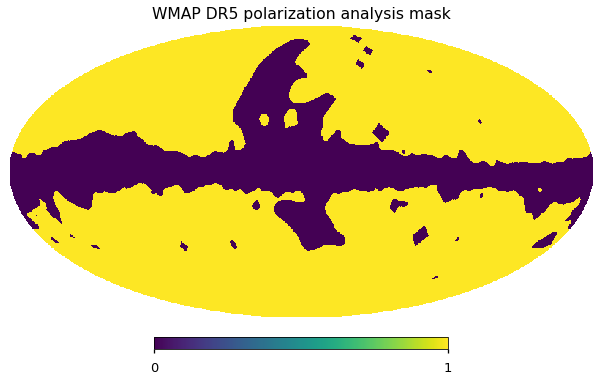

In [10]:
hp.mollview(wmap_mask, title="WMAP DR5 polarization analysis mask")

In [11]:
wmap_mask.sum()/len(wmap_mask)

0.7315705617268881

The Planck foreground mask is also available with apodization of 2 or 5 degrees, here is the one with no apodization

In [12]:
planck_map_filename = "HFI_Mask_GalPlane-apo0_2048_R2.00.fits"

In [13]:
if not os.path.exists(planck_map_filename):
    !wget https://irsa.ipac.caltech.edu/data/Planck/release_2/ancillary-data/masks/$planck_map_filename

In [14]:
fits.open(planck_map_filename)[1].header

XTENSION= 'BINTABLE'           /Written by IDL:  Tue Dec  9 16:45:44 2014       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                    8 /Number of bytes per row                         
NAXIS2  =             50331648 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    8 /Number of columns                               
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
EXTVER  =                    1 /Extension version                               
DATE    = '2014-12-09'      

In [15]:
planck_gal80_mask = hp.read_map(planck_map_filename, ("GAL080",))

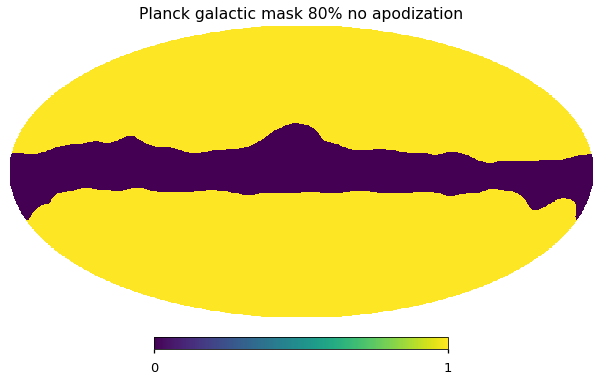

In [16]:
hp.mollview(planck_gal80_mask, title="Planck galactic mask 80% no apodization")

We need to downgrade the Planck mask from 2048 to 1024, so we average 4 pixels, we consider a pixel un-masked if 3 of the 4 pixels are unmasked.

In [17]:
# total_mask = np.logical_and(hp.ud_grade(wmap_mask, nside), hp.ud_grade(planck_gal80_mask, nside)>=.75)

We can check how many pixels have the value of 0,0.25,0.5,0.75,1

In [18]:
np.bincount((4*hp.ud_grade(planck_gal80_mask, nside)).astype(np.int64))

array([ 2511882,     3288,     1665,     3317, 10062760])

In [19]:
total_mask = hp.ud_grade(planck_gal80_mask, nside)>=.75

In [20]:
hp.write_map("total_mask.fits", total_mask.astype(np.int), overwrite=True)

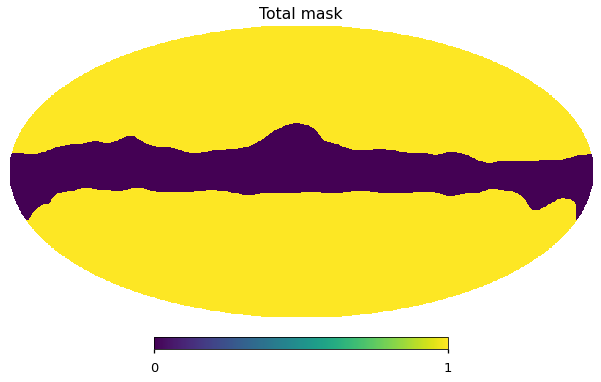

In [21]:
hp.mollview(total_mask, title="Total mask")

## Planck dust polarization

Download the dust polarization map from Commander, see:

https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/previews/COM_CompMap_DustPol-commander_1024_R2.00/index.html

We are trying to reproduce the PySM 2 results so we are using the Commander release 2 results. Later on we can switch to the last Planck release.

In [22]:
commander_dust_map_filename = "COM_CompMap_DustPol-commander_1024_R2.00.fits"

In [23]:
if not os.path.exists(commander_dust_map_filename):
    !wget https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/component-maps/foregrounds/$commander_dust_map_filename

The input map has no temperature, we repeat the Q component for T as well,
this doesn't impact the polarization spectra:

In [24]:
m_planck,h = hp.read_map("./COM_CompMap_DustPol-commander_1024_R2.00.fits", (0,0,1), h=True)

In [25]:
h

[('XTENSION', 'BINTABLE'),
 ('BITPIX', 8),
 ('NAXIS', 2),
 ('NAXIS1', 56),
 ('NAXIS2', 12582912),
 ('PCOUNT', 0),
 ('GCOUNT', 1),
 ('TFIELDS', 14),
 ('COMMENT', ''),
 ('COMMENT', ' *** End of mandatory fields ***'),
 ('COMMENT', ''),
 ('EXTNAME', 'COMP-MAP-DustPol'),
 ('EXTVER', 1),
 ('DATE', '2014-12-11'),
 ('COMMENT', ''),
 ('COMMENT', ' *** Column names ***'),
 ('COMMENT', ''),
 ('TTYPE1', 'Q_ML_FULL'),
 ('TTYPE2', 'U_ML_FULL'),
 ('TTYPE3', 'Q_ML_HM1'),
 ('TTYPE4', 'U_ML_HM1'),
 ('TTYPE5', 'Q_ML_HM2'),
 ('TTYPE6', 'U_ML_HM2'),
 ('TTYPE7', 'Q_ML_HR1'),
 ('TTYPE8', 'U_ML_HR1'),
 ('TTYPE9', 'Q_ML_HR2'),
 ('TTYPE10', 'U_ML_HR2'),
 ('TTYPE11', 'Q_ML_YR1'),
 ('TTYPE12', 'U_ML_YR1'),
 ('TTYPE13', 'Q_ML_YR2'),
 ('TTYPE14', 'U_ML_YR2'),
 ('COMMENT', ''),
 ('COMMENT', ' *** Column formats ***'),
 ('COMMENT', ''),
 ('TFORM1', 'E'),
 ('TFORM2', 'E'),
 ('TFORM3', 'E'),
 ('TFORM4', 'E'),
 ('TFORM5', 'E'),
 ('TFORM6', 'E'),
 ('TFORM7', 'E'),
 ('TFORM8', 'E'),
 ('TFORM9', 'E'),
 ('TFORM10', 'E'),
 

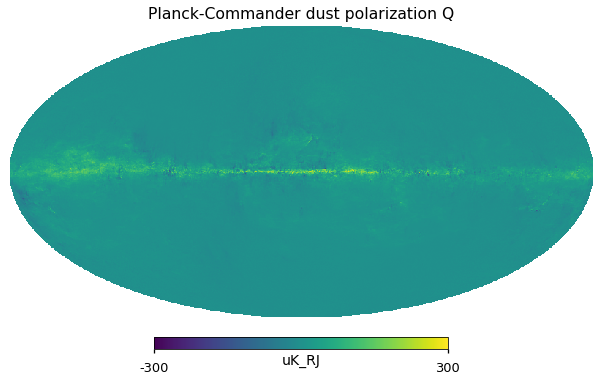

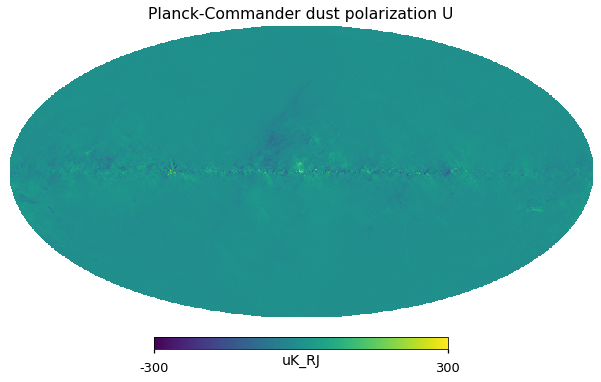

In [26]:
for i_pol, pol in [(1, "Q"), (2, "U")]:
    hp.mollview(m_planck[i_pol], title="Planck-Commander dust polarization " + pol, unit="uK_RJ", min=-300, max=300)

In [27]:
# A T map set to 0 is not supported by PolSpice
m_planck[0] = 1

## Angular power spectrum with NaMaster

In [28]:
import pymaster as nmt

In [29]:
f_2 = nmt.NmtField(total_mask, m_planck[1:])

In [31]:
binning = nmt.NmtBin.from_nside_linear(nside, 1)

In [32]:
binning.lmax

3071

In [33]:
cl_22 = nmt.compute_full_master(f_2, f_2, binning)

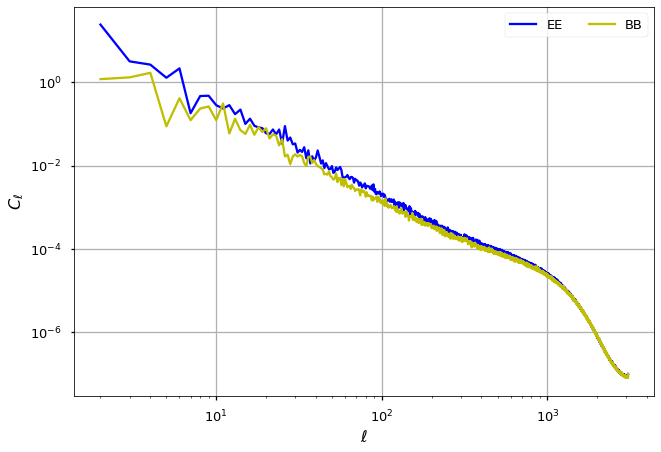

In [40]:
ell_arr = binning.get_effective_ells()
plt.plot(ell_arr, cl_22[0], 'b-', label='EE')
plt.plot(ell_arr, cl_22[3], 'y-', label='BB')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.grid()
plt.show()

In [46]:
ell_arr = np.concatenate([[0,0], ell_arr])

In [47]:
spice_cl = np.zeros((3, len(ell_arr)), dtype=np.double)

In [48]:
spice_cl[1, 2:] = cl_22[0]

In [49]:
spice_cl[2, 2:] = cl_22[3]

## Angular power spectrum with PolSpice

We use PolSpice to estimate the power spectrum of the masked map,
compared to `anafast`, PolSpice properly deconvolves the mask to remove the
correlations between different $C_\ell$ caused by the mask.

We don't need to deconvolve the beam, we won't be using the values at high $\ell$ anyway.

In [28]:
from ispice import ispice

In [29]:
import time

In [33]:
def run_spice(input_map, mask_filename="total_mask.fits"):
    binpath=!which spice
    binpath= str(binpath[-1])
    hp.write_map("polspice_input.fits", input_map, overwrite=True)
    ispice("polspice_input.fits", "spice_cl.fits", binpath=binpath,
           beam1=10,
       polarization=True, pixelfile=True, pixelfile2=False, decouple=False, subav=False, maskfile1=mask_filename)
    assert time.time() - os.path.getmtime("spice_cl.fits") < 10, "Spice possibly crashed, the output file is more than 10 seconds old"
    return hp.read_cl("spice_cl.fits")

In [ ]:
spice_cl = run_spice(m_planck)

In [35]:
spice_cl.shape

(6, 3072)

In [52]:
ell = np.arange(spice_cl.shape[1])
cl_norm = ell*(ell+1)/np.pi/2

We plot the output power spectrum and also identify a range in $\ell$ before white noise starts dominating
and after the uncertainty at low-$\ell$.

The power spectrum features a power law behaviour $\ell < 200$ (linear in `loglog` axes), then white noise
starts picking up until $\ell=1000$ and then we see the smoothing applied to the maps (10 arcminutes).

In [53]:
ell_fit_low = 50
ell_fit_high = 200

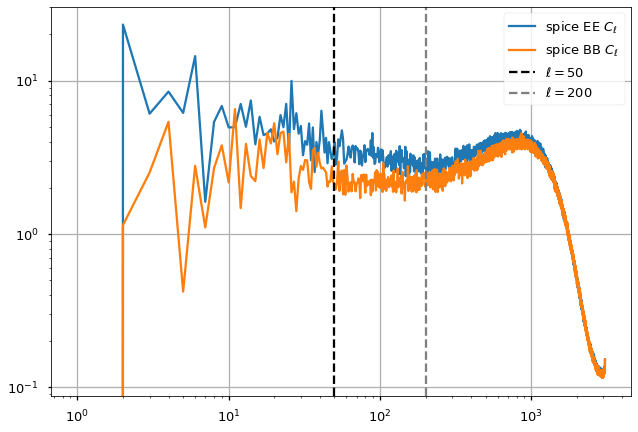

In [55]:
plt.loglog(cl_norm * spice_cl[1], label="spice EE $C_\ell$")
plt.loglog(cl_norm * spice_cl[2], label="spice BB $C_\ell$")
plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
plt.legend()
plt.grid();

In [56]:
from scipy.optimize import curve_fit

In [57]:
def model(ell, A, gamma):
    return A * ell ** gamma

In [58]:
xdata = np.arange(ell_fit_low, ell_fit_high)

/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.
/global/u2/z/zonca/condanamaster/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.


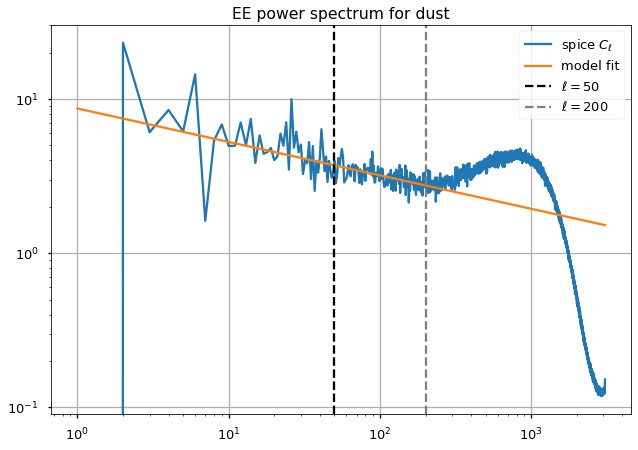

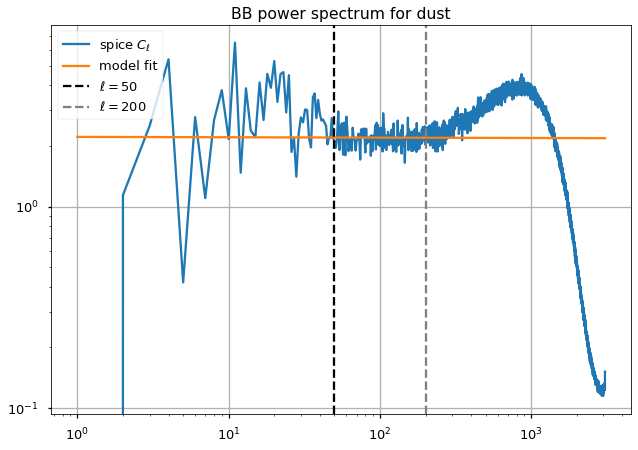

In [59]:
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
for pol,i_pol in [("EE",1),("BB",2)]:
    ydata = xdata*(xdata+1)/np.pi/2 * spice_cl[i_pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))
    plt.figure()
    plt.loglog(ell*(ell+1)/np.pi/2 * spice_cl[i_pol], label="spice $C_\ell$")

    plt.loglog(A_fit[pol]*ell**gamma_fit[pol], label="model fit")
    plt.axvline(ell_fit_low, linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low))
    plt.axvline(ell_fit_high, linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high))
    plt.legend()
    plt.grid()
    plt.title(f"{pol} power spectrum for dust")
    #plt.xlim(0, 400)
    #plt.ylim(1, 30);

In [60]:
A_fit, A_fit_std

({'EE': 8.672547704250396, 'BB': 2.2185427992267694},
 {'EE': 0.957666764183437, 'BB': 0.2445933238280759})

In [61]:
gamma_fit, gamma_fit_std

({'EE': -0.2169002619603586, 'BB': -0.0018187758390616606},
 {'EE': 0.023463162643927123, 'BB': 0.02310948418777236})

Here is the first problem, the paper mentions a $\gamma^{EE,dust} = -.31$ and a $\gamma^{BB,dust} = -.15$. Here instead the BB spectrum in particular is very flat.


### Window function

The window function is used to smooth the input templates to remove the high $\ell$ noise and its inverse is used for the added small scales.

$\ell_*^{dust}$

In [42]:
ell_star = 69

In [43]:
theta_fwhm_deg = 180/ell_star

In [44]:
theta_fwhm_deg

2.608695652173913

In [45]:
theta_fwhm = np.radians(theta_fwhm_deg)

In [46]:
w_ell = hp.gauss_beam(fwhm=theta_fwhm, lmax=lmax)

In [47]:
w_ell.shape

(3072,)

## Process patches

This process doesn't have a large impact on the output spectra, the idea is that in each $N_{side}=2$ pixel we want to scale the gaussian fluctuations so that they are consistent with the power at low ell.
So we will have higher gaussian fluctuations on the galaxy where there is stronger dust emission.

In [48]:
patch_indices = hp.ud_grade(np.arange(hp.nside2npix(2)), nside)

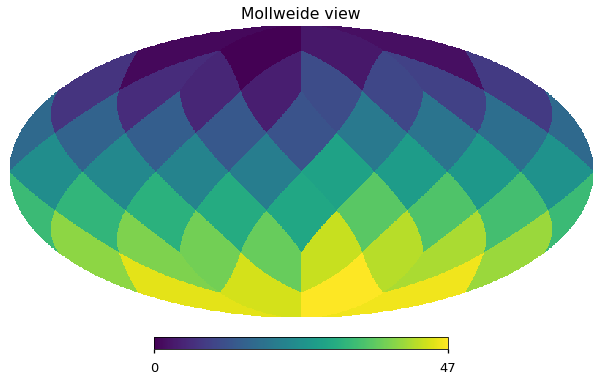

In [49]:
hp.mollview(patch_indices)

In [50]:
zeros = np.zeros(len(ell), dtype=np.double)

In [51]:
inv_w_ell = 1 - w_ell**2

In [52]:
nside_patches = 2
n_patches = hp.nside2npix(nside_patches)

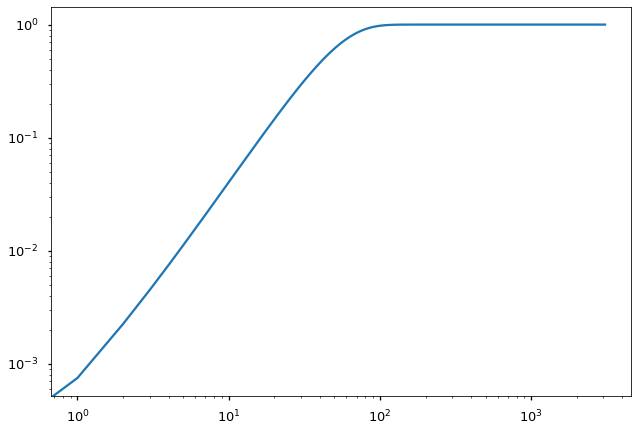

In [53]:
plt.loglog(inv_w_ell)

In [54]:
m_sigma_G = hp.synfast([
    zeros,
    A_fit["EE"] * ell**gamma_fit["EE"] * inv_w_ell / cl_norm,A_fit["BB"] * ell**gamma_fit["BB"] * inv_w_ell / cl_norm,
    zeros, zeros, zeros], nside, new=True)

/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
N = {i_pol:np.zeros(n_patches, dtype=np.double) for i_pol in [1,2]}

In [56]:
m_planck[0] = 0

In [57]:
m_planck_smoothed = hp.alm2map(hp.smoothalm(hp.map2alm(m_planck, use_pixel_weights=True), fwhm=theta_fwhm),
                               nside=nside)

In [58]:
for i_patch in range(n_patches):
    print(i_patch)
    m_patch = np.zeros_like(m_planck_smoothed)
    m_patch[1:, patch_indices == i_patch] = m_planck_smoothed[1:, patch_indices == i_patch]
    cl_patch = hp.anafast(m_patch, lmax=2*ell_star, use_pixel_weights=True)
    for pol,i_pol in [("EE", 1),("BB",2)]:
        N[i_pol][i_patch] = np.sqrt(cl_patch[i_pol][ell_star] / n_patches / (A_fit[pol] * ell_star ** gamma_fit[pol]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


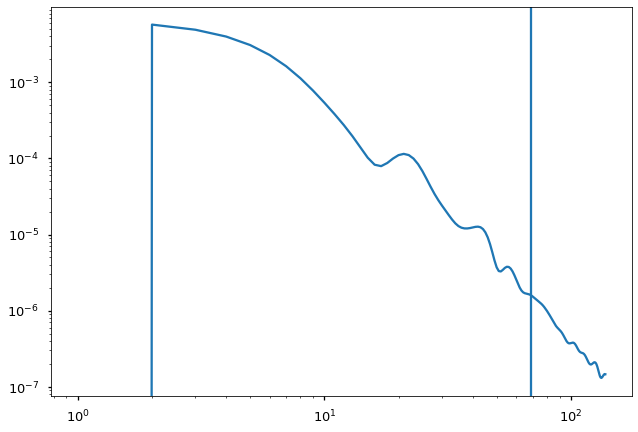

In [59]:
plt.loglog(cl_patch[1])
plt.axvline(ell_star)

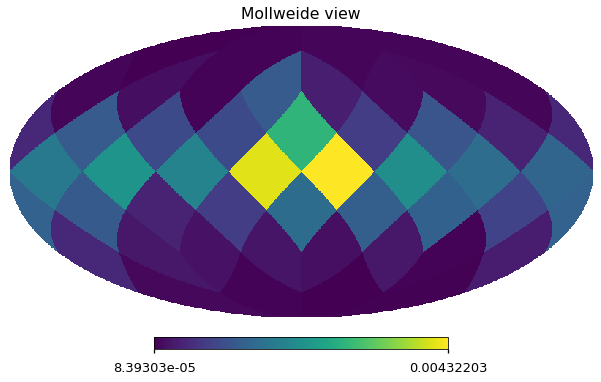

In [60]:
hp.mollview(N[1])

In [61]:
m_zeros = np.zeros(hp.nside2npix(nside), dtype=np.double)

In [62]:
N_smoothed = hp.smoothing([m_zeros, hp.ud_grade(N[1], nside), hp.ud_grade(N[2], nside)], fwhm=np.radians(10))

In [63]:
N_smoothed[1] /= N_smoothed[1].mean()

In [64]:
N_smoothed[2] /= N_smoothed[2].mean() 

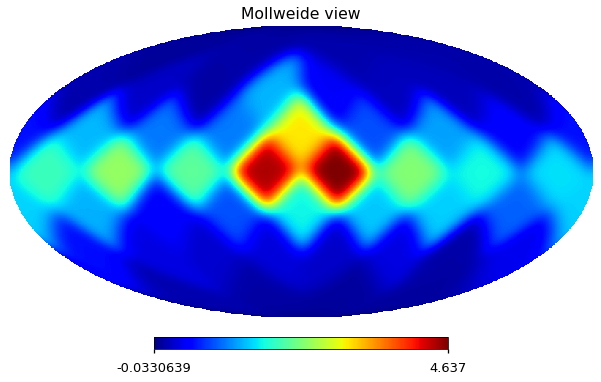

In [65]:
hp.mollview(N_smoothed[1], cmap="jet")

This also is quite different from Figure 9 in the paper, but it is not the main issue, possibly I need to use PolSpice instead of anafast?

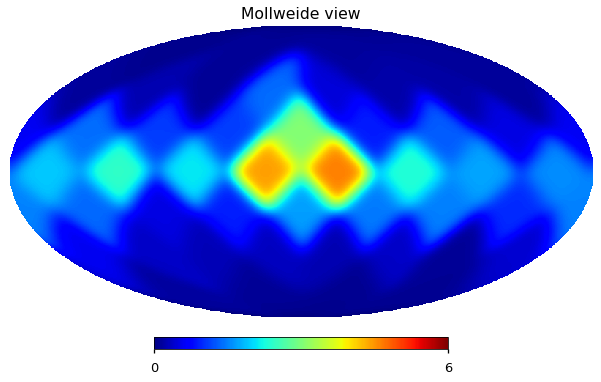

In [66]:
hp.mollview(N_smoothed[1], min=0, max=6, cmap="jet")

## Run PolSpice on the total map and just on the small scales

Always using the same Gal80 Planck mask

In [67]:
m_total = m_planck_smoothed + m_sigma_G * N_smoothed

In [68]:
m_total[0] = 1

In [69]:
cl_total = run_spice(m_total)

Submitting job 0
/global/homes/z/zonca/condajupynersc/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile spice_cl.fits -decouple NO -mapfile polspice_input.fits -fits_out YES -maskfile total_mask.fits -nlmax -1 -normfac 1.0 -npairsthreshold 0.00000 -overwrite YES -polarization YES -pixelfile NO -pixelfile2 NO -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity 2 -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 
 ===> HEALPIXDATA not defined, trying HEALPIX...
 ===> Using HEALPIXDATA=/global/homes/z/zonca/condajupynersc/Healpix_3.70/data/
 Check header for file polspice_input.fits
 nside for input map file =        1024
 Check header for file total_mask.fits
 nside for input map file =        1024

 SpICE 3.7.0_DP has been called with the following attributes : 

 nside detected...         1024
 max multipole used        3071
 polarization..... YES
 map file (1)......
     1.000 *   polspice_input.fits
 mask file....(TP

In [70]:
m_sigma_G[0]=1

In [71]:
N_smoothed[0]=1

In [72]:
cl_sigma_G_normalized = run_spice(m_sigma_G * N_smoothed)

Submitting job 0
/global/homes/z/zonca/condajupynersc/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile spice_cl.fits -decouple NO -mapfile polspice_input.fits -fits_out YES -maskfile total_mask.fits -nlmax -1 -normfac 1.0 -npairsthreshold 0.00000 -overwrite YES -polarization YES -pixelfile NO -pixelfile2 NO -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity 2 -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 
 ===> HEALPIXDATA not defined, trying HEALPIX...
 ===> Using HEALPIXDATA=/global/homes/z/zonca/condajupynersc/Healpix_3.70/data/
 Check header for file polspice_input.fits
 nside for input map file =        1024
 Check header for file total_mask.fits
 nside for input map file =        1024

 SpICE 3.7.0_DP has been called with the following attributes : 

 nside detected...         1024
 max multipole used        3071
 polarization..... YES
 map file (1)......
     1.000 *   polspice_input.fits
 mask file....(TP

## Download PySM 2 templates

In [73]:
for comp in "tqu":
    filename = f"dust_{comp}_new.fits"
    if not os.path.exists(filename):
        !wget https://portal.nersc.gov/project/cmb/pysm-data/pysm_2/$filename

In [74]:
total_mask.shape

(12582912,)

In [75]:
hp.ud_grade(total_mask, 512)>=.75

array([ True,  True,  True, ...,  True,  True,  True])

In [77]:
hp.write_map("total_mask_512.fits", hp.ud_grade(total_mask, 512)>=.75, overwrite=True)

In [78]:
m_pysm2 = [hp.read_map(f"dust_{comp}_new.fits") for comp in "tqu"]

In [79]:
cl_pysm2 = run_spice(m_pysm2, mask_filename="total_mask_512.fits")

Submitting job 0
/global/homes/z/zonca/condajupynersc/bin/spice -apodizesigma NO -apodizetype 0 -beam NO -beam2 NO -clfile spice_cl.fits -decouple NO -mapfile polspice_input.fits -fits_out YES -maskfile total_mask_512.fits -nlmax -1 -normfac 1.0 -npairsthreshold 0.00000 -overwrite YES -polarization YES -pixelfile NO -pixelfile2 NO -subav NO -subdipole NO -symmetric_cl NO -thetamax NO -tolerance NO -verbosity 2 -weightpower 1.0 -weightpower2 1.0 -weightpowerp 1.0 -weightpowerp2 1.0 
 ===> HEALPIXDATA not defined, trying HEALPIX...
 ===> Using HEALPIXDATA=/global/homes/z/zonca/condajupynersc/Healpix_3.70/data/
 Check header for file polspice_input.fits
 nside for input map file =         512
 Check header for file total_mask_512.fits
 nside for input map file =         512

 SpICE 3.7.0_DP has been called with the following attributes : 

 nside detected...          512
 max multipole used        1535
 polarization..... YES
 map file (1)......
     1.000 *   polspice_input.fits
 mask fil

## Compare PySM 2, the input and the output

/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


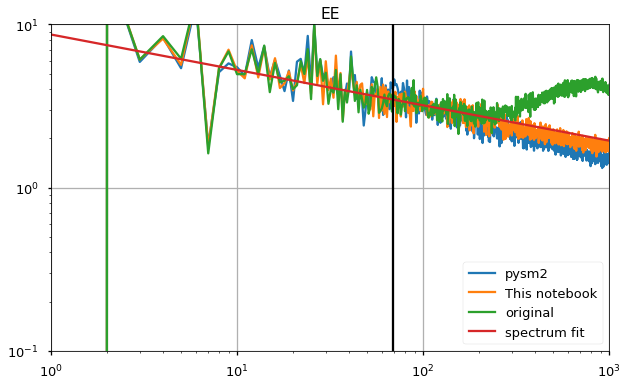

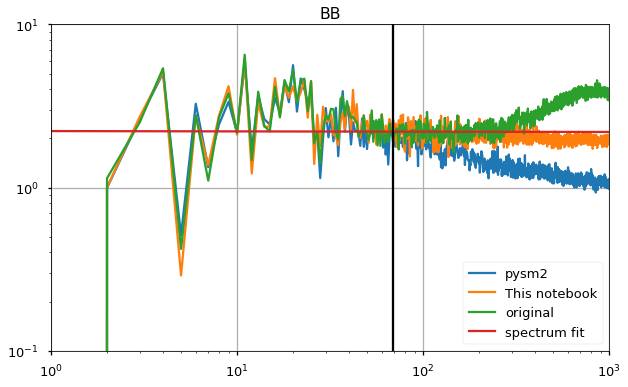

In [80]:
for pol, i_pol in [("EE",1),("BB",2)]:
    plt.figure(figsize=(10,6))
    plt.loglog(cl_norm[:cl_pysm2.shape[1]]*cl_pysm2[i_pol], label="pysm2")
    #plt.loglog(cl_norm*cl_sigma_G_normalized[i_pol], label="SS")
    plt.loglog(cl_norm*cl_total[i_pol], label="This notebook")

    plt.loglog(cl_norm*spice_cl[i_pol], label="original")

    plt.loglog(A_fit[pol] * ell**gamma_fit[pol], label="spectrum fit")
    plt.axvline(ell_star, color="black")
    plt.title(pol)
    plt.legend()
    plt.xlim([1,1000])
    plt.ylim([1e-1, 1e1])
    plt.grid();

We can also compare with the dust BB plot (Figure 7) from the PySM 2 paper below,
the main issue is the shape of the BB Spectrum.

![BB Dust PySM 2 Paper](BB_dust_PySM_2_paper.png)

# 